# Portfolio's Building #

### Rebalancing Weights ###

In [2]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from functions import import_financial_data
from portfolios_toolkit import calculate_analytics
from portfolios_toolkit import markowitz_weights

In [3]:
# Import Data

# Apple Data
df_1 = import_financial_data("AAPL")

# Amazon Data
df_2 =  import_financial_data("AMZN")

# Meta Data
df_3 =  import_financial_data("META")

# Microsoft Data
df_4 =  import_financial_data("MSFT")

# Nvidia Data
df_5 =  import_financial_data("NVDA")

In [4]:
# Create the joint dataframe

df_data = pd.DataFrame()

df_data['AAPL'] = df_1['adj_close']
df_data['AMZN'] = df_2['adj_close']
df_data['META'] = df_3['adj_close']
df_data['MSFT'] = df_4['adj_close']
df_data['NVDA'] = df_5['adj_close']

df_data = df_data.dropna()

df_returns = df_data.pct_change(1)
df_returns = df_returns.apply(lambda x: x.fillna(x.mean()), axis=0)

df_returns

,AAPL,AMZN,META,MSFT,NVDA
Date,,,,,
2015-01-02,0.001031,0.001225,0.001093,0.001042,0.002749
2015-01-05,-0.028172,-0.020517,-0.016061,-0.009303,-0.016890
2015-01-06,0.000094,-0.022833,-0.013473,-0.014571,-0.030318
2015-01-07,0.014022,0.010600,0.000000,0.012705,-0.002866
2015-01-08,0.038422,0.006836,0.026592,0.029418,0.037889
...,...,...,...,...,...
2024-10-22,-0.002622,0.003332,0.011910,0.020846,-0.000835
2024-10-23,-0.021623,-0.026305,-0.031477,-0.006807,-0.028066
2024-10-24,-0.000823,0.009041,0.007256,0.000306,0.006091


In [5]:
df_returns.mean()

AAPL    0.001031
AMZN    0.001225
META    0.001093
MSFT    0.001042
NVDA    0.002749
dtype: float64

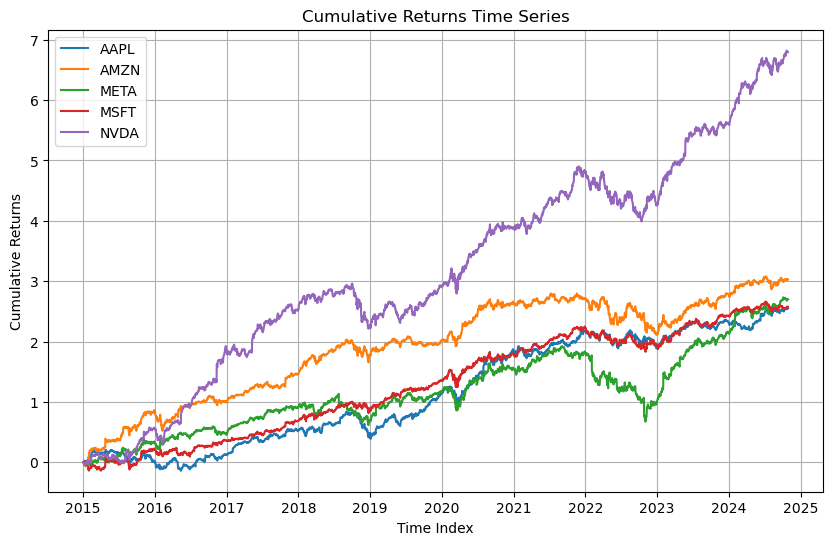

In [6]:
# Time Series Graphs
plt.figure(figsize=(10, 6))
plt.plot(df_returns.cumsum(), label=df_returns.columns, alpha=1)

# Config
plt.title('Cumulative Returns Time Series')
plt.xlabel('Time Index')
plt.ylabel('Cumulative Returns')
plt.legend()

# Show
plt.grid(True)
plt.show()

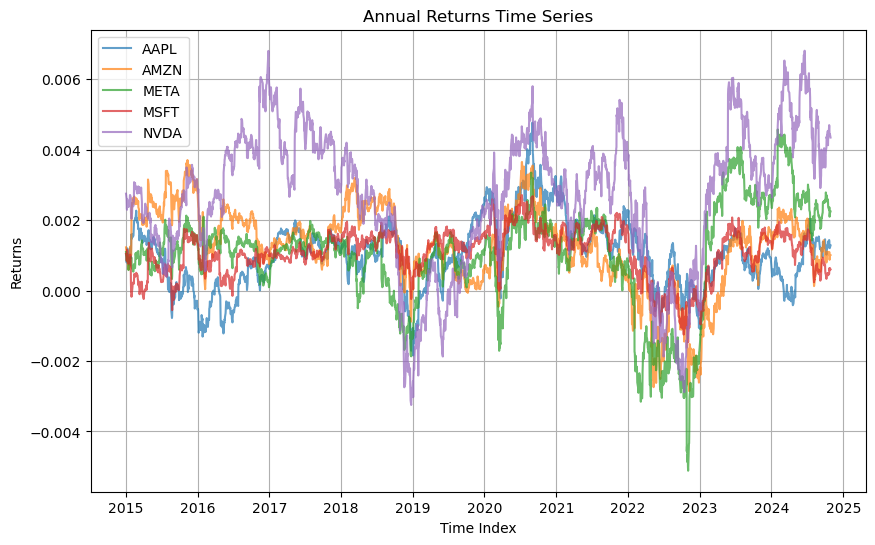

In [7]:
# Time Series Graphs
plt.figure(figsize=(10, 6))
plt.plot(df_returns.ewm(span=252, adjust=False).mean(), label=df_returns.columns, alpha=0.7)

# Config
plt.title('Annual Returns Time Series')
plt.xlabel('Time Index')
plt.ylabel('Returns')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [8]:
# Create the DataFrame with average returns

df_mean_returns = df_returns.apply(lambda x: x.ewm(span=252, adjust=False).mean().mul(252), axis=0)

df_mean_returns

,AAPL,AMZN,META,MSFT,NVDA
Date,,,,,
2015-01-02,0.259835,0.308792,0.275418,0.262559,0.692733
2015-01-05,0.201661,0.265478,0.241245,0.241951,0.653610
2015-01-06,0.200254,0.217894,0.212498,0.211012,0.588046
2015-01-07,0.226604,0.237287,0.210818,0.234654,0.577688
2015-01-08,0.301354,0.249029,0.262126,0.291403,0.648599
...,...,...,...,...,...
2024-10-22,0.353164,0.274445,0.595414,0.159983,1.172112
2024-10-23,0.307297,0.219874,0.528002,0.145158,1.106936
2024-10-24,0.303228,0.236146,0.538282,0.144621,1.110319


In [9]:
# Let us Calculate the Weights

def rolling_weights(
    returns, 
    desired_returns, 
    window=252, 
    rebalance_freq=126
):

    # Lists to Store Things
    weights_list = []
    dates = []

    for i in range(window, len(returns), rebalance_freq):
        past_returns = returns.iloc[i - window:i]  # Rolling Window
        past_excepted_returns = past_returns.mean()
        past_cov_matrix = past_returns.cov()

        # Calculate Weights
        w = markowitz_weights(past_excepted_returns, past_cov_matrix, desired_returns)

        # Save weights and dates
        weights_list.append(w)
        dates.append(returns.index[i])

    # Create the DataFrame
    weights_df = pd.DataFrame(weights_list, index=dates, columns=returns.columns)

    # Expand the DataFrame
    weights_df = weights_df.reindex(returns.index, method='ffill')

    return weights_df.dropna()

In [10]:
# Create the DataFrames of Returns

df_weights = rolling_weights(df_returns, 0.002)

df_weights

,AAPL,AMZN,META,MSFT,NVDA
Date,,,,,
2016-01-04,0.079717,0.291163,0.337395,0.032502,0.259223
2016-01-05,0.079717,0.291163,0.337395,0.032502,0.259223
2016-01-06,0.079717,0.291163,0.337395,0.032502,0.259223
2016-01-07,0.079717,0.291163,0.337395,0.032502,0.259223
2016-01-08,0.079717,0.291163,0.337395,0.032502,0.259223
...,...,...,...,...,...
2024-10-22,0.277754,0.119231,0.064504,0.349481,0.189031
2024-10-23,0.277754,0.119231,0.064504,0.349481,0.189031
2024-10-24,0.277754,0.119231,0.064504,0.349481,0.189031


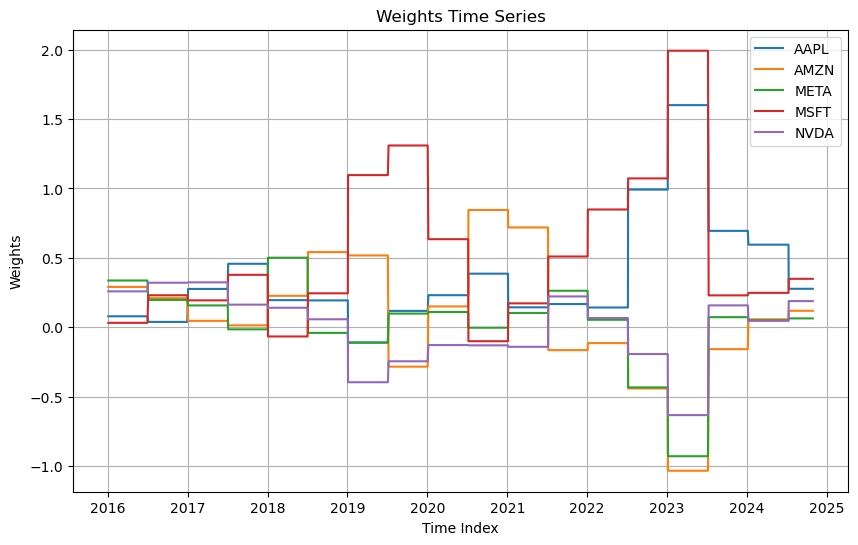

In [11]:
# Time Series Graphs
plt.figure(figsize=(10, 6))
plt.plot(df_weights, label=df_weights.columns, alpha=1)
# Config
plt.title('Weights Time Series')
plt.xlabel('Time Index')
plt.ylabel('Weights')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [12]:
# Common Index

common_index = df_returns.index.intersection(df_weights.index)  # Fechas en común
df_returns_reindex = df_returns.reindex(common_index)
df_weights = df_weights.reindex(common_index)

df_returns_reindex

,AAPL,AMZN,META,MSFT,NVDA
Date,,,,,
2016-01-04,0.000855,-0.057554,-0.023314,-0.012257,-0.017900
2016-01-05,-0.025059,-0.005024,0.004989,0.004562,0.016064
2016-01-06,-0.019570,-0.001799,0.002336,-0.018165,-0.041350
2016-01-07,-0.042205,-0.039058,-0.049043,-0.034783,-0.039645
2016-01-08,0.005288,-0.001464,-0.006025,0.003067,-0.021466
...,...,...,...,...,...
2024-10-22,-0.002622,0.003332,0.011910,0.020846,-0.000835
2024-10-23,-0.021623,-0.026305,-0.031477,-0.006807,-0.028066
2024-10-24,-0.000823,0.009041,0.007256,0.000306,0.006091


In [13]:
# Create the Portfolio Returns

df_weighted_returns = df_returns_reindex * df_weights

df_weighted_returns

,AAPL,AMZN,META,MSFT,NVDA
Date,,,,,
2016-01-04,0.000068,-0.016757,-0.007866,-0.000398,-0.004640
2016-01-05,-0.001998,-0.001463,0.001683,0.000148,0.004164
2016-01-06,-0.001560,-0.000524,0.000788,-0.000590,-0.010719
2016-01-07,-0.003364,-0.011372,-0.016547,-0.001131,-0.010277
2016-01-08,0.000422,-0.000426,-0.002033,0.000100,-0.005565
...,...,...,...,...,...
2024-10-22,-0.000728,0.000397,0.000768,0.007285,-0.000158
2024-10-23,-0.006006,-0.003136,-0.002030,-0.002379,-0.005305
2024-10-24,-0.000229,0.001078,0.000468,0.000107,0.001151


In [14]:
# Create the Portfolio Returns
df_returns_portfolio = df_returns.copy()

# Add the columns
df_returns_portfolio['Portfolio'] =  df_weighted_returns.sum(axis = 1)

df_returns_portfolio['Portfolio'].dropna()

Date
2016-01-04   -0.029594
2016-01-05    0.002536
2016-01-06   -0.012605
2016-01-07   -0.042691
2016-01-08   -0.007503
                ...   
2024-10-22    0.007565
2024-10-23   -0.018857
2024-10-24    0.002576
2024-10-25    0.006896
2024-10-28    0.000661
Name: Portfolio, Length: 2220, dtype: float64

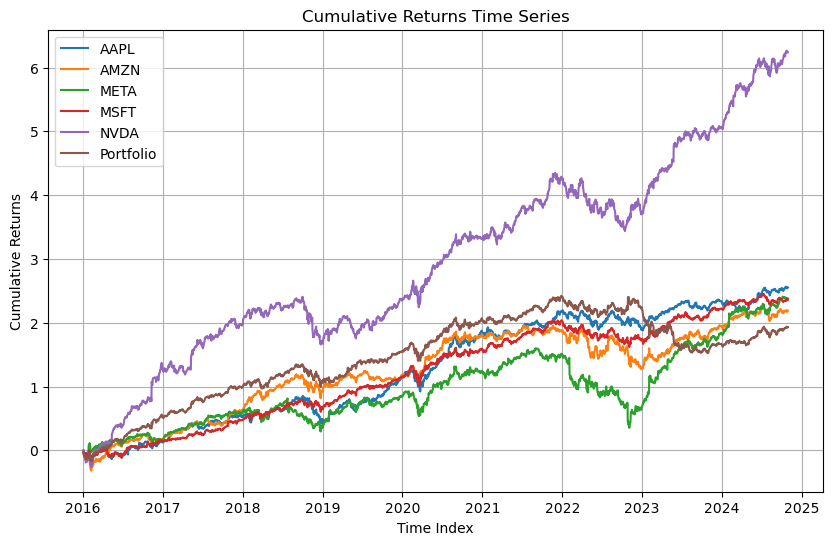

In [15]:
# Time Series Graphs

df_plot = df_returns_portfolio.dropna()

plt.figure(figsize=(10, 6))
plt.plot(df_plot.cumsum(), label=df_plot.columns, alpha=1)

# Config
plt.title('Cumulative Returns Time Series')
plt.xlabel('Time Index')
plt.ylabel('Cumulative Returns')
plt.legend()

# Show
plt.grid(True)
plt.show()

### Define different rebalancing frequencies ###

In [16]:
# Create weights for different rebalancing frequencies

df_weights_5d = rolling_weights(df_returns, 0.0025, rebalance_freq=5)
df_weights_21d = rolling_weights(df_returns, 0.0025, rebalance_freq=21)
df_weights_63d = rolling_weights(df_returns, 0.0025, rebalance_freq=63)
df_weights_126d = rolling_weights(df_returns, 0.0025, rebalance_freq=126)
df_weights_252d = rolling_weights(df_returns, 0.0025, rebalance_freq=252)

In [17]:
# Create the Returns

df_weighted_returns_5d = df_returns_reindex * df_weights_5d
df_weighted_returns_21d = df_returns_reindex * df_weights_21d
df_weighted_returns_63d = df_returns_reindex * df_weights_63d
df_weighted_returns_126d = df_returns_reindex * df_weights_126d
df_weighted_returns_252d = df_returns_reindex * df_weights_252d

In [18]:
# Add the columns

df_returns_reindex['5d_port'] = df_weighted_returns_5d.sum(axis = 1)
df_returns_reindex['21d_port'] = df_weighted_returns_21d.sum(axis = 1)
df_returns_reindex['63d_port'] = df_weighted_returns_63d.sum(axis = 1)
df_returns_reindex['126d_port'] = df_weighted_returns_126d.sum(axis = 1)
df_returns_reindex['252d_port'] = df_weighted_returns_252d.sum(axis = 1)

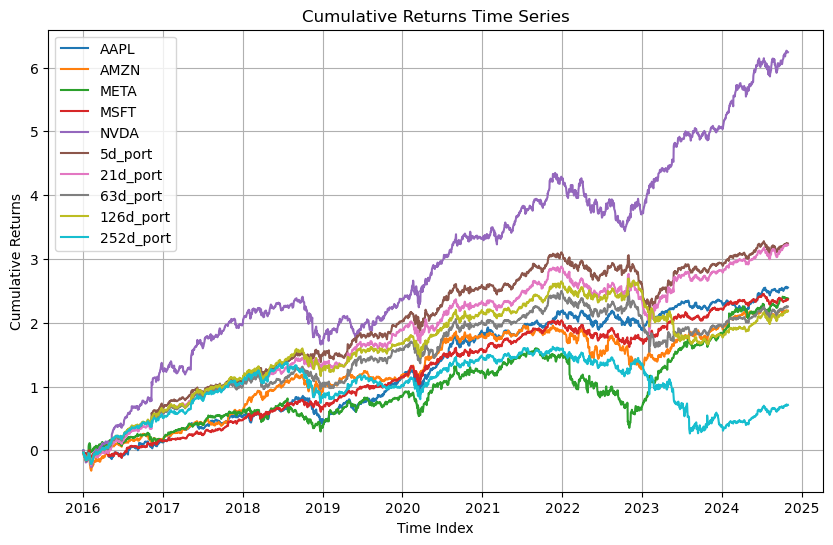

In [19]:
# Time Series Graphs

plt.figure(figsize=(10, 6))
plt.plot(df_returns_reindex.cumsum(), label=df_returns_reindex.columns, alpha=1)

# Config
plt.title('Cumulative Returns Time Series')
plt.xlabel('Time Index')
plt.ylabel('Cumulative Returns')
plt.legend()

# Show
plt.grid(True)
plt.show()

### Comparing Portfolios ###

In [20]:
# Now the table
analytics_table = calculate_analytics(df_returns_reindex)

analytics_table

,Annualized Returns,Annualized Volatility,Sharpe Ratio,Max Drawdown,VaR 95%
AAPL,0.289482,0.288498,1.003412,-0.004629,-0.027187
AMZN,0.248400,0.326751,0.760210,-0.006857,-0.031534
META,0.270091,0.387613,0.696806,-0.012399,-0.035138
MSFT,0.268354,0.270956,0.990398,-0.004162,-0.026590
NVDA,0.708459,0.501556,1.412521,-0.009099,-0.045790
5d_port,0.367671,0.357732,1.027785,-0.009950,-0.033784
21d_port,0.365382,0.365800,0.998857,-0.010549,-0.034184
63d_port,0.255557,0.348143,0.734058,-0.009537,-0.034596
126d_port,0.247366,0.349900,0.706962,-0.010315,-0.035547
252d_port,0.080641,0.368718,0.218707,-0.013517,-0.036497
